[medium](https://medium.com/@dikaelsaputra/advanced-machine-learning-using-spark-mllib-1e5fe3e00ae2)

[github](https://github.com/figuran04/big-data/tree/main/pertemuan-14)

# Hands-On Pertemuan 14: Advanced Machine Learning using Spark MLlib

## Objectives:
- Understand and implement advanced machine learning tasks using Spark MLlib.
- Build and evaluate models using real-world datasets.
- Explore techniques like feature engineering and hyperparameter tuning.


## Introduction to Spark MLlib
Spark MLlib is a scalable library for machine learning that integrates seamlessly with the Spark ecosystem. It supports a wide range of tasks, including regression, classification, clustering, and collaborative filtering.

In [ ]:
# Example: Linear Regression with Spark MLlib
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Initialize Spark Session
spark = SparkSession.builder.appName('MLlib Example').getOrCreate()

# Load sample data
data = [(1, 5.0, 20.0), (2, 10.0, 25.0), (3, 15.0, 30.0), (4, 20.0, 35.0)]
columns = ['ID', 'Feature', 'Target']
df = spark.createDataFrame(data, columns)

# Prepare data for modeling
assembler = VectorAssembler(inputCols=['Feature'], outputCol='Features')
df_transformed = assembler.transform(df)

# Train a linear regression model
lr = LinearRegression(featuresCol='Features', labelCol='Target')
model = lr.fit(df_transformed)

# Print model coefficients
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')


Coefficients: [0.9999999999999992]
Intercept: 15.000000000000009


In [ ]:
# Practice: Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vector

# Example dataset
data = [(1, Vectors.dense([2.0, 3.0]), 0), (2, Vectors.dense([1.0, 5.0]), 1), (3, Vectors.dense([2.5, 4.5]), 1), (4, Vectors.dense([3.0, 6.0]), 0)]
columns = ['ID', 'Features', 'Label']
df = spark.createDataFrame(data, columns)

# Train logistic regression model
lr = LogisticRegression(featuresCol='Features', labelCol='Label')
model = lr.fit(df)

# Display coefficients and summary
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')


Coefficients: [-12.262057921492042,4.087352263925821]
Intercept: 11.568912718955037


In [ ]:
# Practice: KMeans Clustering
from pyspark.ml.clustering import KMeans

# Example dataset
data = [(1, Vectors.dense([1.0, 1.0])), (2, Vectors.dense([5.0, 5.0])), (3, Vectors.dense([10.0, 10.0])), (4, Vectors.dense([15.0, 15.0]))]
columns = ['ID', 'Features']
df = spark.createDataFrame(data, columns)

# Train KMeans clustering model
kmeans = KMeans(featuresCol='Features', k=2)
model = kmeans.fit(df)

# Show cluster centers
centers = model.clusterCenters()
print(f'Cluster Centers: {centers}')


Cluster Centers: [array([5.33333333, 5.33333333]), array([15., 15.])]


## Homework
- Load a real-world dataset into Spark and prepare it for machine learning tasks.
- Build a classification model using Spark MLlib and evaluate its performance.
- Explore hyperparameter tuning using cross-validation.


In [29]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score


spark = SparkSession.builder.appName("TitanicPrediction").getOrCreate()

url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic_pd = pd.read_csv(url)

threshold = 0.5 * len(titanic_pd)
titanic_pd.dropna(thresh=threshold, axis=1, inplace=True)
titanic_pd['Age'] = titanic_pd['Age'].fillna(titanic_pd['Age'].mean())
titanic_pd['Embarked'] = titanic_pd['Embarked'].fillna('S')

missing_data = titanic_pd.isnull().sum()
print("Nilai yang hilang per kolom:\n", missing_data)

titanic_spark = spark.createDataFrame(titanic_pd)

indexers = [
    StringIndexer(inputCol="Sex", outputCol="Sex_Index"),
    StringIndexer(inputCol="Embarked", outputCol="Embarked_Index")
]

encoders = [
    OneHotEncoder(inputCol="Sex_Index", outputCol="Sex_Encoded"),
    OneHotEncoder(inputCol="Embarked_Index", outputCol="Embarked_Encoded")
]

feature_cols = ["Pclass", "Sex_Encoded", "Age", "SibSp", "Parch", "Fare", "Embarked_Encoded"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="Survived",
                        aggregationDepth=2, elasticNetParam=0.0, family='auto',
                        fitIntercept=True, maxBlockSizeInMB=0.0, maxIter=100,
                        predictionCol="prediction", probabilityCol="probability",
                        rawPredictionCol="rawPrediction", regParam=0.01,
                        standardization=True, threshold=0.5, tol=1e-06)

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

train_data, test_data = titanic_spark.randomSplit([0.8, 0.2], seed=123)

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1, 10, 100]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="Survived", metricName="areaUnderROC")
cross_val = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

cv_model = cross_val.fit(train_data)

best_model = cv_model.bestModel

predictions = best_model.transform(test_data)

auc = evaluator.evaluate(predictions)
print("Area Under ROC:", auc)

Nilai yang hilang per kolom:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
Area Under ROC: 0.8426071878940733


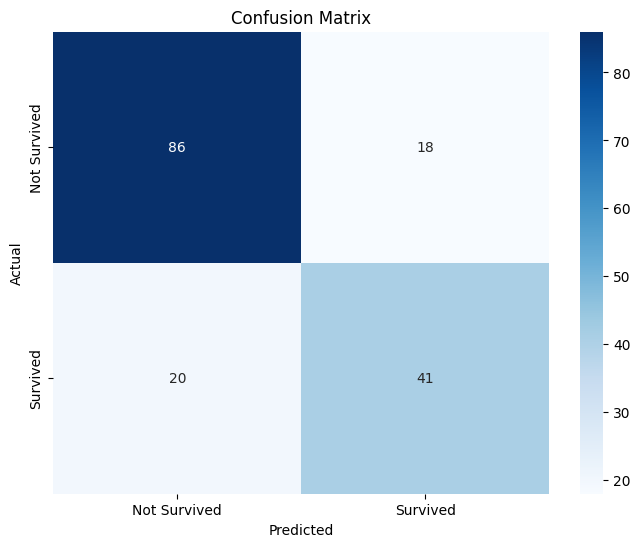

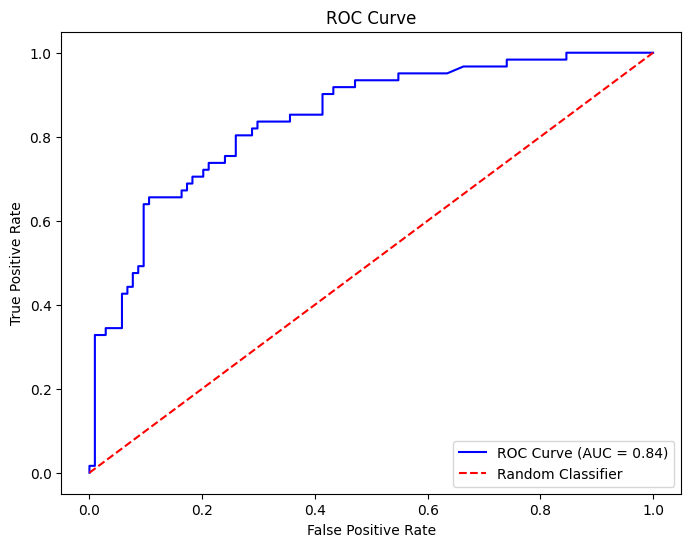

In [32]:
conf_matrix = confusion_matrix(predictions.select('Survived').collect(), predictions.select('prediction').collect())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_true = predictions.select('Survived').rdd.flatMap(lambda x: x).collect()
y_proba = predictions.select('probability').rdd.flatMap(lambda x: x).collect()
y_proba = [p[1] for p in y_proba]
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = roc_auc_score(y_true, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()